In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [4]:
train_dir = '/content/drive/My Drive/Colab Notebooks/HMT_train' #you should change to your directory
test_dir = '/content/drive/My Drive/Colab Notebooks/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [5]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [5]:
model=load_model('HMT.h5')

In [7]:
predict = model.predict(test_generator,steps=16)

Overall classification accuracy on test set: 0.8346774193548387


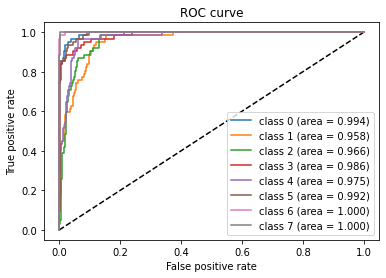

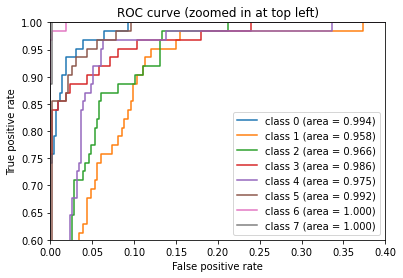

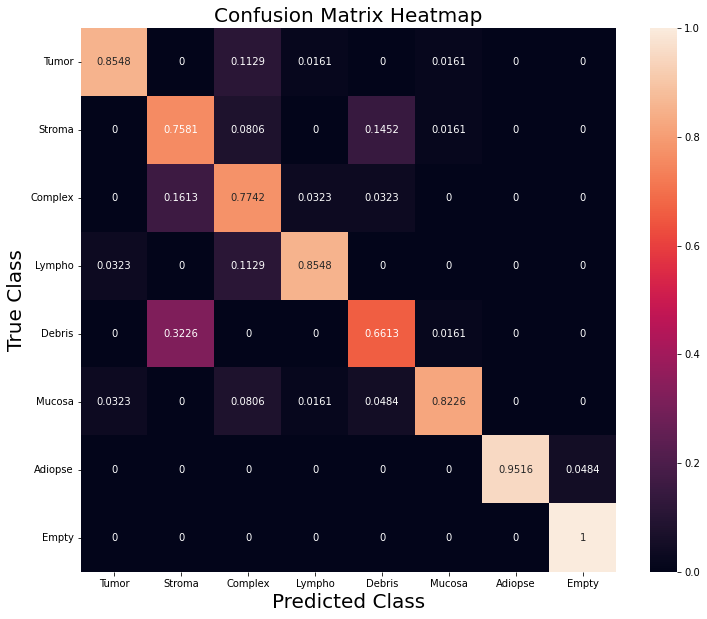

class wise accuracy: [0.97379032 0.88306452 0.85080645 0.89314516 0.90927419 0.97177419
 0.99395161 0.99395161]
precision: [0.92982456 0.61038961 0.66666667 0.92982456 0.74545455 0.94444444
 1.         0.95384615]
recall: [0.85483871 0.75806452 0.77419355 0.85483871 0.66129032 0.82258065
 0.9516129  1.        ]
f1: [0.8907563  0.67625899 0.71641791 0.8907563  0.7008547  0.87931034
 0.97520661 0.97637795]


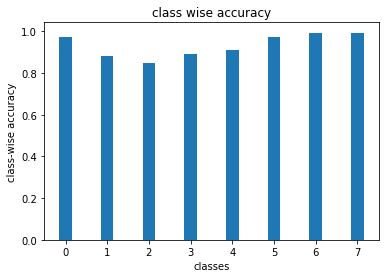

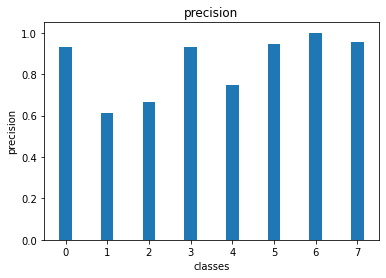

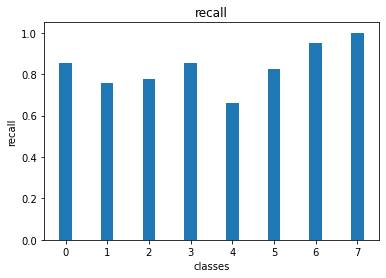

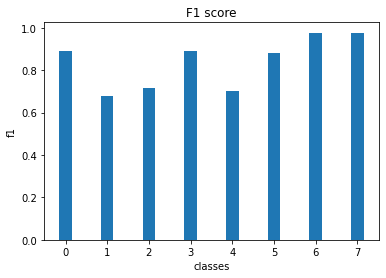

In [8]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

test_generator.reset()
y_predict = np.argmax(predict, axis=1)
labels = []

for i in range(16):
  _,label_batch=test_generator.next()
  for j in range(label_batch.shape[0]):
    labels.append(label_batch[j])
labels = np.array(labels)
y_labels = np.argmax(labels, axis=1)

### classification accuracy on test set
correct_prediction_count = 0
for i in range(496):
  if y_predict[i] == y_labels[i]:
    correct_prediction_count = correct_prediction_count+1

print("Overall classification accuracy on test set: " + str(correct_prediction_count/496))

### ROC and AUC for each class
# referenced https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a.
class_prob_0 = predict[:,0]
class_prob_1 = predict[:,1]
class_prob_2 = predict[:,2]
class_prob_3 = predict[:,3]
class_prob_4 = predict[:,4]
class_prob_5 = predict[:,5]
class_prob_6 = predict[:,6]
class_prob_7 = predict[:,7]

class_truth_0 = labels[:,0]
class_truth_1 = labels[:,1]
class_truth_2 = labels[:,2]
class_truth_3 = labels[:,3]
class_truth_4 = labels[:,4]
class_truth_5 = labels[:,5]
class_truth_6 = labels[:,6]
class_truth_7 = labels[:,7]

fpr_0, tpr_0, _ = roc_curve(class_truth_0, class_prob_0)
fpr_1, tpr_1, _ = roc_curve(class_truth_1, class_prob_1)
fpr_2, tpr_2, _ = roc_curve(class_truth_2, class_prob_2)
fpr_3, tpr_3, _ = roc_curve(class_truth_3, class_prob_3)
fpr_4, tpr_4, _ = roc_curve(class_truth_4, class_prob_4)
fpr_5, tpr_5, _ = roc_curve(class_truth_5, class_prob_5)
fpr_6, tpr_6, _ = roc_curve(class_truth_6, class_prob_6)
fpr_7, tpr_7, _ = roc_curve(class_truth_7, class_prob_7)

auc_0 = auc(fpr_0, tpr_0)
auc_1 = auc(fpr_1, tpr_1)
auc_2 = auc(fpr_2, tpr_2)
auc_3 = auc(fpr_3, tpr_3)
auc_4 = auc(fpr_4, tpr_4)
auc_5 = auc(fpr_5, tpr_5)
auc_6 = auc(fpr_6, tpr_6)
auc_7 = auc(fpr_7, tpr_7)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_0, tpr_0, label='class 0 (area = {:.3f})'.format(auc_0))
plt.plot(fpr_1, tpr_1, label='class 1 (area = {:.3f})'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='class 2 (area = {:.3f})'.format(auc_2))
plt.plot(fpr_3, tpr_3, label='class 3 (area = {:.3f})'.format(auc_3))
plt.plot(fpr_4, tpr_4, label='class 4 (area = {:.3f})'.format(auc_4))
plt.plot(fpr_5, tpr_5, label='class 5 (area = {:.3f})'.format(auc_5))
plt.plot(fpr_6, tpr_6, label='class 6 (area = {:.3f})'.format(auc_6))
plt.plot(fpr_7, tpr_7, label='class 7 (area = {:.3f})'.format(auc_7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# zoom in the top-left cornor
plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_0, tpr_0, label='class 0 (area = {:.3f})'.format(auc_0))
plt.plot(fpr_1, tpr_1, label='class 1 (area = {:.3f})'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='class 2 (area = {:.3f})'.format(auc_2))
plt.plot(fpr_3, tpr_3, label='class 3 (area = {:.3f})'.format(auc_3))
plt.plot(fpr_4, tpr_4, label='class 4 (area = {:.3f})'.format(auc_4))
plt.plot(fpr_5, tpr_5, label='class 5 (area = {:.3f})'.format(auc_5))
plt.plot(fpr_6, tpr_6, label='class 6 (area = {:.3f})'.format(auc_6))
plt.plot(fpr_7, tpr_7, label='class 7 (area = {:.3f})'.format(auc_7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

### confusion matrix
# referenced https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python.
confusion_matrix = confusion_matrix(y_labels, y_predict)
confusion_matrix_plot = np.round((confusion_matrix/confusion_matrix.max()), 4)
class_labels = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

fig = plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(confusion_matrix_plot, annot=True, ax = ax, fmt = 'g')

ax.set_xlabel('Predicted Class', fontsize=20)
ax.xaxis.set_label_position('bottom')
ax.xaxis.set_ticklabels(class_labels, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Class', fontsize=20)
ax.yaxis.set_ticklabels(class_labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix Heatmap', fontsize=20)
plt.show()

### class-wise accuracy
class_accur = np.zeros(8)
class_accur[0] = (confusion_matrix[0][0] + confusion_matrix[1:8, 1:8].sum()) /496
class_accur[1] = (confusion_matrix[1][1] + confusion_matrix[2:8, 2:8].sum() + confusion_matrix[0][0]) /496
class_accur[2] = (confusion_matrix[2][2] + confusion_matrix[3:8, 3:8].sum() + confusion_matrix[0:2, 0:2].sum()) /496
class_accur[3] = (confusion_matrix[3][3] + confusion_matrix[4:8, 4:8].sum() + confusion_matrix[0:3, 0:3].sum()) /496
class_accur[4] = (confusion_matrix[4][4] + confusion_matrix[5:8, 5:8].sum() + confusion_matrix[0:4, 0:4].sum()) /496
class_accur[5] = (confusion_matrix[5][5] + confusion_matrix[6:8, 6:8].sum() + confusion_matrix[0:5, 0:5].sum()) /496
class_accur[6] = (confusion_matrix[6][6] + confusion_matrix[7][7] + confusion_matrix[0:6, 0:6].sum()) /496
class_accur[7] = (confusion_matrix[7][7] + confusion_matrix[0:7, 0:7].sum()) /496

### Precision
precision = np.zeros(8)
precision[0] = confusion_matrix[0][0] / sum(confusion_matrix[:, 0])
precision[1] = confusion_matrix[1][1] / sum(confusion_matrix[:, 1])
precision[2] = confusion_matrix[2][2] / sum(confusion_matrix[:, 2])
precision[3] = confusion_matrix[3][3] / sum(confusion_matrix[:, 3])
precision[4] = confusion_matrix[4][4] / sum(confusion_matrix[:, 4])
precision[5] = confusion_matrix[5][5] / sum(confusion_matrix[:, 5])
precision[6] = confusion_matrix[6][6] / sum(confusion_matrix[:, 6])
precision[7] = confusion_matrix[7][7] / sum(confusion_matrix[:, 7])

### Recall
recall = np.zeros(8)
recall[0] = confusion_matrix[0][0] / sum(confusion_matrix[0])
recall[1] = confusion_matrix[1][1] / sum(confusion_matrix[1])
recall[2] = confusion_matrix[2][2] / sum(confusion_matrix[2])
recall[3] = confusion_matrix[3][3] / sum(confusion_matrix[3])
recall[4] = confusion_matrix[4][4] / sum(confusion_matrix[4])
recall[5] = confusion_matrix[5][5] / sum(confusion_matrix[5])
recall[6] = confusion_matrix[6][6] / sum(confusion_matrix[6])
recall[7] = confusion_matrix[7][7] / sum(confusion_matrix[7])

### F1
f1 = np.zeros(8)
f1[0] = (2* precision[0] * recall[0]) / (precision[0] + recall[0])
f1[1] = (2* precision[1] * recall[1]) / (precision[1] + recall[1])
f1[2] = (2* precision[2] * recall[2]) / (precision[2] + recall[2])
f1[3] = (2* precision[3] * recall[3]) / (precision[3] + recall[3])
f1[4] = (2* precision[4] * recall[4]) / (precision[4] + recall[4])
f1[5] = (2* precision[5] * recall[5]) / (precision[5] + recall[5])
f1[6] = (2* precision[6] * recall[6]) / (precision[6] + recall[6])
f1[7] = (2* precision[7] * recall[7]) / (precision[7] + recall[7])

# 
print("class wise accuracy: " + str(class_accur))
print("precision: " + str(precision))
print("recall: " + str(recall))
print("f1: " + str(f1))

# visualize the meatures
class_accu_array = np.array(class_accur)
precision_array = np.array(precision)
recall_array = np.array(recall)
f1_array = np.array(f1)

xxx = np.arange(8)
bar_width = 0.3

plt.figure(10)
plt.bar(xxx, pd.Series(class_accu_array), bar_width)
plt.title('class wise accuracy')
plt.xlabel('classes')
plt.ylabel('class-wise accuracy')
plt.show()

plt.figure(10)
plt.bar(xxx, pd.Series(precision), bar_width)
plt.title('precision')
plt.xlabel('classes')
plt.ylabel('precision')
plt.show()

plt.figure(10)
plt.bar(xxx, pd.Series(recall), bar_width)
plt.title('recall')
plt.xlabel('classes')
plt.ylabel('recall')
plt.show()

plt.figure(10)
plt.bar(xxx, pd.Series(f1), bar_width)
plt.title('F1 score')
plt.xlabel('classes')
plt.ylabel('f1')
plt.show()
##

In [ ]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Text(0.5, 1.0, 'Training progress: Accuracy')

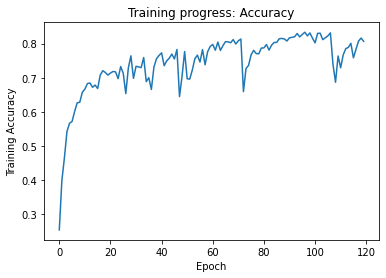

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

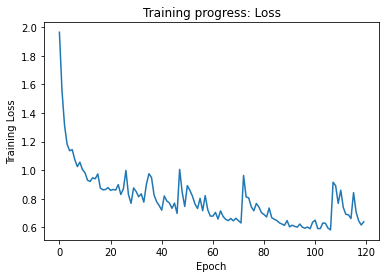

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

Load the explaier library

In [6]:
from xai_utils import *
# grad_cam is chosen

# def grad_cam(input_model, image, layer_name):
#     cls = np.argmax(input_model.predict(image))
#     def normalize(x):
#         """Utility function to normalize a tensor by its L2 norm"""
#         return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
#     """GradCAM method for visualizing input saliency."""
#     y_c = input_model.output
#     conv_output = input_model.get_layer(layer_name).output
#     feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
#     with tf.GradientTape() as tape:
#         ff_results=feedforward1([image])
#         all_fmap_masks, predictions = ff_results[0], ff_results[-1]
#         loss = predictions[:, cls]
#     grads_val = tape.gradient(loss, all_fmap_masks)
#     if len(image.shape)==3:
#         axis=(0, 1)
#     elif len(image.shape)==4:
#         axis=(0, 1, 2)
#     weights = np.mean(grads_val, axis=axis)
#     cam = np.dot(all_fmap_masks[0], weights)
#     #print (cam)
#     H,W= image.shape[1:3]
#     cam = np.maximum(cam, 0)
#     #cam = resize(cam, (H, W))
#     cam = zoom(cam,H/cam.shape[0])
#     #cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
#     return cam

Load a batch of images

In [36]:
test_generator.reset()

In [37]:
image_batch,label_batch=test_generator.next()

Classes:

In [38]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [ ]:
index=8

prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

Generate explanation map

## Lime

In [53]:
import random
import sklearn
import skimage.segmentation as seg
import copy
import skimage.io 
from sklearn.linear_model import Ridge

sample_input = image_batch[index].astype(float)
sample_label_class = np.argmax(label_batch[index])

# following the idea of LIME python library, https://github.com/marcotcr/lime/blob/master/lime/lime_image.py. Using quickshift to get superpixels of the origin image.
superpixel_seg = seg.quickshift(sample_input, kernel_size=4, max_dist=200, ratio=0.2)
n_features = np.unique(superpixel_seg).shape[0]

sample_size = 1000
mask = [[0]*n_features]*sample_size
for i in range(sample_size):
  buff = [0]*n_features
  for j in range(n_features):
    ran = random.uniform(0, 1)
    if ran>0.5:
      buff[j] = 1
  mask[i] = buff
mask = np.array(mask)
mask = np.vstack([np.ones(n_features), mask]).astype(float)

# distance and weight
# metric and kernel chosen referenced the lime library implementation, https://github.com/marcotcr/lime.
original = np.ones(n_features)[np.newaxis,:]
distances = sklearn.metrics.pairwise_distances(mask, original, metric='cosine').ravel()
weights = np.sqrt(np.exp(-(distances ** 2) / 0.25 ** 2))

masked_pred = []
for i in range(sample_size+1):
  perturbed_img = copy.deepcopy(sample_input)
  active_seg = np.where(mask[i] >0.5)[0]
  perturb_map = np.zeros(superpixel_seg.shape)

  for j in active_seg:
    perturb_map[superpixel_seg == j] = 1

  perturbed_img = perturbed_img * perturb_map[:,:,np.newaxis]
  # skimage.io.imshow(perturbed_img)

  pred = model.predict(np.expand_dims(perturbed_img, axis=0))
  masked_pred.append(pred[0])
masked_pred = np.array(masked_pred)
masked_pred_class = masked_pred[:, sample_label_class]

# Choose a linear model for explanation, just follow what the paper has mentioned.
sparse_linear_model = Ridge(alpha=1, fit_intercept=True)
sparse_linear_model.fit(mask, masked_pred_class, sample_weight=weights)


Ridge(alpha=1)

In [ ]:
exp_lime = sparse_linear_model.coef_
exp_lime = exp_lime / exp_lime.max()

expl_map = np.zeros(superpixel_seg.shape)
for i in range(n_features):
  expl_map[superpixel_seg == i] = exp_lime[i]

plt.figure(1)
plt.imshow(image_batch[index])
plt.imshow(expl_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (LIME)')

In [ ]:
thresho = 20
imp_segs = np.argsort(exp_lime)[-thresho:] 

expl_map = np.zeros(superpixel_seg.shape)
for i in imp_segs:
  expl_map[superpixel_seg == i] = 1
expl_img = copy.deepcopy(sample_input)
expl_img = expl_img * expl_map[:,:,np.newaxis]
skimage.io.imshow(expl_img)

## Let's Try LIME library, just for performance comparison 
### (Seems like the library excutes faster...)

In [ ]:
# # ### Optionally try the performance of the official lime library

# !pip install lime
# import lime
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [ ]:
# explainer = lime_image.LimeImageExplainer()
# explanation = explainer.explain_instance(sample_input.astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)

# buff = []
# buff.append(sample_input)
# model.predict(np.array(buff))

# img, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [ ]:
# layers=[['conv2d_3']]

In [ ]:
# %%time
# explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
# explanation_map_SISE -= explanation_map_SISE.min()
# explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 3.85 s, sys: 221 ms, total: 4.07 s
Wall time: 3.55 s


## Grad-CAM (Gradient-based Class Activation Mapping)

In [41]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 68.1 ms, sys: 4.06 ms, total: 72.1 ms
Wall time: 70.3 ms


## RISE (Randomized Input Sampling for Explanation)

In [ ]:
# %%time
# explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
# explanation_map_RISE -= explanation_map_RISE.min()
# explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 1min 40s, sys: 1.19 s, total: 1min 41s
Wall time: 54.1 s


## Plot the results

In [ ]:
#@title Plot the results

plt.figure(2)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

# plt.subplot(1,4,2)
# plt.imshow(image_batch[index])
# plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
# plt.axis('off')
# plt.title('Explanation map (SISE)')

plt.figure(3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

# plt.subplot(1,4,4)
# plt.imshow(image_batch[index])
# plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
# plt.axis('off')
# plt.title('Explanation map (RISE)')

## Quantitative evaluation of the explanation algorithm

In [31]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
test_generator.reset()
drop_rate_grad = 0.
drop_rate_lime = 0.

increase_rate_grad = 0.
increase_rate_lime = 0.

for k in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
      prediction=model(image_batch)

      ### grad cam
      explanation_map_grad = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
      drop_rate_grad += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_grad, class_index=np.argmax(prediction[index]), frac=0.9)[0]
      increase_rate_grad += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_grad, class_index=np.argmax(prediction[index]), frac=0.9)[1]

      ### lime
      sample_input = image_batch[index].astype(float)
      sample_label_class = np.argmax(label_batch[index])

      # following the idea of LIME python library, https://github.com/marcotcr/lime/blob/master/lime/lime_image.py. Using quickshift to get superpixels of the origin image.
      superpixel_seg = seg.quickshift(sample_input, kernel_size=4, max_dist=200, ratio=0.2)
      n_features = np.unique(superpixel_seg).shape[0]

      sample_size = 1000
      mask = [[0]*n_features]*sample_size
      for i in range(sample_size):
        buff = [0]*n_features
        for j in range(n_features):
          ran = random.uniform(0, 1)
          if ran>0.5:
            buff[j] = 1
        mask[i] = buff
      mask = np.array(mask)
      mask = np.vstack([np.ones(n_features), mask]).astype(float)

      # distance and weight
      # metric and kernel chosen referenced the lime library implementation, https://github.com/marcotcr/lime.
      original = np.ones(n_features)[np.newaxis,:]
      distances = sklearn.metrics.pairwise_distances(mask, original, metric='cosine').ravel()
      weights = np.sqrt(np.exp(-(distances ** 2) / 0.25 ** 2))

      masked_pred = []
      for i in range(sample_size+1):
        perturbed_img = copy.deepcopy(sample_input)
        active_seg = np.where(mask[i] >0.5)[0]
        perturb_map = np.zeros(superpixel_seg.shape)

        for j in active_seg:
          perturb_map[superpixel_seg == j] = 1
        
        perturbed_img = perturbed_img * perturb_map[:,:,np.newaxis]
        # skimage.io.imshow(perturbed_img)

        pred = model.predict(np.expand_dims(perturbed_img, axis=0))
        masked_pred.append(pred[0])
      masked_pred = np.array(masked_pred)
      masked_pred_class = masked_pred[:, sample_label_class]

      # Choose a linear model for explanation, just follow what the paper has mentioned.
      sparse_linear_model = Ridge(alpha=1, fit_intercept=True)
      sparse_linear_model.fit(mask, masked_pred_class, sample_weight=weights)

      exp_lime = sparse_linear_model.coef_
      exp_lime = exp_lime / exp_lime.max()

      expl_map_lime = np.zeros(superpixel_seg.shape)
      for i in range(n_features):
        expl_map_lime[superpixel_seg == i] = exp_lime[i]

      drop_rate_lime += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, expl_map_lime, class_index=np.argmax(prediction[index]), frac=0.9)[0]
      increase_rate_lime += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, expl_map_lime, class_index=np.argmax(prediction[index]), frac=0.9)[1]
    # print("loop: " + str(k))

drop_rate_grad /= (15*32)
increase_rate_grad /= (15*32)

drop_rate_lime /= (15*32)
increase_rate_lime /= (15*32)

print("lime drop: " + str(drop_rate_lime))
print("lime increase: " + str(increase_rate_lime))

print("grad cam drop: " + str(drop_rate_grad))
print("grad cam increase: " + str(increase_rate_grad))